In [114]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm
import wandb

In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)# cudaが利用可能だと0

cuda:0


In [116]:
wandb.init(
    project="mnist_test",
    config={
        "learning_rate": 0.05,
        "epochs": 100,
        "batch_size": 128*1
    }
)

In [117]:
# 最終的なデータセットの定義
data_root = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])
train_set = datasets.MNIST(
    root = data_root, train=True, download=False, transform=transform
)
test_set = datasets.MNIST(
    root = data_root, train=False, download=False, transform=transform
)

In [118]:
from torch.utils.data import DataLoader
batch_size = wandb.config["batch_size"]

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False
)

In [119]:
# 入出力、隠れ層の設定
image, label = train_set[0]
n_input = image.shape[0]
for images, labels in train_loader:
    break
n_output = len(set(list(labels.data.numpy())))
n_hidden = 128

In [120]:
# モデルの定義
# 784入力10出力２隠れ層のNNモデル
class Net1(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層1
        self.l1 = nn.Linear(n_input, n_hidden)
        # 出力層
        self.l2 = nn.Linear(n_hidden, n_output)
        # ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l3(x2)
        return x3

# NN層の定義
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = wandb.config["learning_rate"]
# モデル初期化
net = Net1(n_input, n_output, n_hidden).to(device)
print(net)

Net1(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [121]:
# モデルの定義
# 784入力10出力２隠れ層のNNモデル
class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層1
        self.l1 = nn.Linear(n_input, n_hidden)
        # 隠れ層2
        self.l2 = nn.Linear(n_hidden, n_hidden)
        # 出力層
        self.l3 = nn.Linear(n_hidden, n_output)
        # ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

# NN層の定義
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = wandb.config["learning_rate"]
# モデル初期化
net = Net2(n_input, n_output, n_hidden).to(device)
print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [122]:
# 損失関数：交差エントロピー関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=lr)
# 繰り返し回数
num_epochs = wandb.config["epochs"]
# 評価関数結果記録用
history = np.zeros((0,5))

In [123]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    test_acc, test_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)
        # GPUへ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 勾配の初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = net(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配計算
        loss.backward()
        # パラメータ修正
        optimizer.step()
        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]
        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    # 予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失関数
        loss_test = criterion(outputs_test, labels_test)


        # 予測データ導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と制度の計算
        test_loss += loss_test.item()
        test_acc += (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    test_acc = test_acc / n_test
    train_loss = train_loss * batch_size / n_train
    test_loss = test_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {test_loss:.5f}, val_acc: {test_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, test_loss, test_acc])
    history = np.vstack((history, item))
    wandb.log({"epoch": epoch, "train_loss": train_loss, "test_loss": test_loss})
print(f'初期状態：損失：{history[0,3]:.5f}  精度：{history[0,4]:.5f}')
print(f'最終状態：損失：{history[-1,3]:.5f}  精度：{history[-1,4]:.5f}')

100%|██████████| 469/469 [00:02<00:00, 187.39it/s]


Epoch [1/100], loss: 0.66534 acc: 0.79918 val_loss: 0.32924, val_acc: 0.89840


100%|██████████| 469/469 [00:02<00:00, 198.06it/s]


Epoch [2/100], loss: 0.28924 acc: 0.91273 val_loss: 0.23791, val_acc: 0.92880


100%|██████████| 469/469 [00:02<00:00, 195.36it/s]


Epoch [3/100], loss: 0.22382 acc: 0.93392 val_loss: 0.19688, val_acc: 0.94230


100%|██████████| 469/469 [00:02<00:00, 194.90it/s]


Epoch [4/100], loss: 0.18320 acc: 0.94450 val_loss: 0.16843, val_acc: 0.94890


100%|██████████| 469/469 [00:02<00:00, 199.09it/s]


Epoch [5/100], loss: 0.15606 acc: 0.95358 val_loss: 0.13920, val_acc: 0.95810


100%|██████████| 469/469 [00:02<00:00, 196.58it/s]


Epoch [6/100], loss: 0.13404 acc: 0.96010 val_loss: 0.13267, val_acc: 0.95930


100%|██████████| 469/469 [00:02<00:00, 198.87it/s]


Epoch [7/100], loss: 0.11985 acc: 0.96458 val_loss: 0.13367, val_acc: 0.95840


100%|██████████| 469/469 [00:02<00:00, 194.33it/s]


Epoch [8/100], loss: 0.10708 acc: 0.96820 val_loss: 0.11358, val_acc: 0.96400


100%|██████████| 469/469 [00:02<00:00, 194.54it/s]


Epoch [9/100], loss: 0.09494 acc: 0.97202 val_loss: 0.10024, val_acc: 0.96680


100%|██████████| 469/469 [00:02<00:00, 195.58it/s]


Epoch [10/100], loss: 0.08624 acc: 0.97405 val_loss: 0.09983, val_acc: 0.96970


100%|██████████| 469/469 [00:02<00:00, 199.17it/s]


Epoch [11/100], loss: 0.07861 acc: 0.97653 val_loss: 0.08985, val_acc: 0.97110


100%|██████████| 469/469 [00:02<00:00, 198.22it/s]


Epoch [12/100], loss: 0.07196 acc: 0.97888 val_loss: 0.09291, val_acc: 0.97070


100%|██████████| 469/469 [00:02<00:00, 197.45it/s]


Epoch [13/100], loss: 0.06724 acc: 0.97987 val_loss: 0.08659, val_acc: 0.97340


100%|██████████| 469/469 [00:02<00:00, 198.15it/s]


Epoch [14/100], loss: 0.06123 acc: 0.98165 val_loss: 0.08380, val_acc: 0.97210


100%|██████████| 469/469 [00:02<00:00, 197.22it/s]


Epoch [15/100], loss: 0.05745 acc: 0.98307 val_loss: 0.07855, val_acc: 0.97580


100%|██████████| 469/469 [00:02<00:00, 196.09it/s]


Epoch [16/100], loss: 0.05283 acc: 0.98432 val_loss: 0.08222, val_acc: 0.97550


100%|██████████| 469/469 [00:02<00:00, 197.80it/s]


Epoch [17/100], loss: 0.04964 acc: 0.98530 val_loss: 0.07493, val_acc: 0.97740


100%|██████████| 469/469 [00:02<00:00, 196.16it/s]


Epoch [18/100], loss: 0.04598 acc: 0.98690 val_loss: 0.07902, val_acc: 0.97550


100%|██████████| 469/469 [00:02<00:00, 197.12it/s]


Epoch [19/100], loss: 0.04252 acc: 0.98765 val_loss: 0.08063, val_acc: 0.97430


100%|██████████| 469/469 [00:02<00:00, 197.52it/s]


Epoch [20/100], loss: 0.04036 acc: 0.98783 val_loss: 0.07347, val_acc: 0.97760


100%|██████████| 469/469 [00:02<00:00, 195.41it/s]


Epoch [21/100], loss: 0.03659 acc: 0.98947 val_loss: 0.28552, val_acc: 0.89900


100%|██████████| 469/469 [00:02<00:00, 192.40it/s]


Epoch [22/100], loss: 0.05550 acc: 0.98423 val_loss: 0.08020, val_acc: 0.97520


100%|██████████| 469/469 [00:02<00:00, 198.12it/s]


Epoch [23/100], loss: 0.03325 acc: 0.99073 val_loss: 0.06828, val_acc: 0.97890


100%|██████████| 469/469 [00:02<00:00, 196.08it/s]


Epoch [24/100], loss: 0.03081 acc: 0.99115 val_loss: 0.06918, val_acc: 0.97840


100%|██████████| 469/469 [00:02<00:00, 196.69it/s]


Epoch [25/100], loss: 0.02872 acc: 0.99203 val_loss: 0.06723, val_acc: 0.97970


100%|██████████| 469/469 [00:02<00:00, 197.89it/s]


Epoch [26/100], loss: 0.02643 acc: 0.99265 val_loss: 0.06969, val_acc: 0.97850


100%|██████████| 469/469 [00:02<00:00, 198.18it/s]


Epoch [27/100], loss: 0.02521 acc: 0.99300 val_loss: 0.06949, val_acc: 0.97890


100%|██████████| 469/469 [00:02<00:00, 195.85it/s]


Epoch [28/100], loss: 0.02311 acc: 0.99377 val_loss: 0.07044, val_acc: 0.97820


100%|██████████| 469/469 [00:02<00:00, 195.63it/s]


Epoch [29/100], loss: 0.02187 acc: 0.99445 val_loss: 0.06697, val_acc: 0.97930


100%|██████████| 469/469 [00:02<00:00, 194.31it/s]


Epoch [30/100], loss: 0.02013 acc: 0.99490 val_loss: 0.07196, val_acc: 0.97790


100%|██████████| 469/469 [00:02<00:00, 196.81it/s]


Epoch [31/100], loss: 0.01903 acc: 0.99525 val_loss: 0.07250, val_acc: 0.97740


100%|██████████| 469/469 [00:02<00:00, 192.25it/s]


Epoch [32/100], loss: 0.01727 acc: 0.99597 val_loss: 0.07603, val_acc: 0.97690


100%|██████████| 469/469 [00:02<00:00, 194.73it/s]


Epoch [33/100], loss: 0.01703 acc: 0.99582 val_loss: 0.08616, val_acc: 0.97560


100%|██████████| 469/469 [00:02<00:00, 196.67it/s]


Epoch [34/100], loss: 0.01578 acc: 0.99637 val_loss: 0.07448, val_acc: 0.97870


100%|██████████| 469/469 [00:02<00:00, 197.36it/s]


Epoch [35/100], loss: 0.01469 acc: 0.99655 val_loss: 0.07246, val_acc: 0.97840


100%|██████████| 469/469 [00:02<00:00, 197.03it/s]


Epoch [36/100], loss: 0.01285 acc: 0.99720 val_loss: 0.07111, val_acc: 0.97950


100%|██████████| 469/469 [00:02<00:00, 194.97it/s]


Epoch [37/100], loss: 0.01283 acc: 0.99715 val_loss: 0.07308, val_acc: 0.97890


100%|██████████| 469/469 [00:02<00:00, 190.87it/s]


Epoch [38/100], loss: 0.01139 acc: 0.99785 val_loss: 0.07113, val_acc: 0.97910


100%|██████████| 469/469 [00:02<00:00, 189.78it/s]


Epoch [39/100], loss: 0.01073 acc: 0.99778 val_loss: 0.06759, val_acc: 0.97980


100%|██████████| 469/469 [00:02<00:00, 195.69it/s]


Epoch [40/100], loss: 0.01011 acc: 0.99800 val_loss: 0.07550, val_acc: 0.97790


100%|██████████| 469/469 [00:02<00:00, 194.85it/s]


Epoch [41/100], loss: 0.00965 acc: 0.99802 val_loss: 0.07013, val_acc: 0.98040


100%|██████████| 469/469 [00:02<00:00, 193.63it/s]


Epoch [42/100], loss: 0.00917 acc: 0.99820 val_loss: 0.07300, val_acc: 0.97870


100%|██████████| 469/469 [00:02<00:00, 195.33it/s]


Epoch [43/100], loss: 0.00815 acc: 0.99872 val_loss: 0.07287, val_acc: 0.97840


100%|██████████| 469/469 [00:02<00:00, 190.12it/s]


Epoch [44/100], loss: 0.00781 acc: 0.99870 val_loss: 0.07306, val_acc: 0.97800


100%|██████████| 469/469 [00:02<00:00, 196.20it/s]


Epoch [45/100], loss: 0.00739 acc: 0.99887 val_loss: 0.07046, val_acc: 0.97950


100%|██████████| 469/469 [00:02<00:00, 195.22it/s]


Epoch [46/100], loss: 0.00661 acc: 0.99917 val_loss: 0.07320, val_acc: 0.97900


100%|██████████| 469/469 [00:02<00:00, 195.21it/s]


Epoch [47/100], loss: 0.00634 acc: 0.99907 val_loss: 0.07333, val_acc: 0.97930


100%|██████████| 469/469 [00:02<00:00, 193.46it/s]


Epoch [48/100], loss: 0.00588 acc: 0.99913 val_loss: 0.07293, val_acc: 0.97930


100%|██████████| 469/469 [00:02<00:00, 193.98it/s]


Epoch [49/100], loss: 0.00530 acc: 0.99950 val_loss: 0.07355, val_acc: 0.97840


100%|██████████| 469/469 [00:02<00:00, 196.51it/s]


Epoch [50/100], loss: 0.00503 acc: 0.99955 val_loss: 0.07179, val_acc: 0.98030


100%|██████████| 469/469 [00:02<00:00, 194.49it/s]


Epoch [51/100], loss: 0.00487 acc: 0.99950 val_loss: 0.07850, val_acc: 0.97800


100%|██████████| 469/469 [00:02<00:00, 198.17it/s]


Epoch [52/100], loss: 0.00439 acc: 0.99957 val_loss: 0.07545, val_acc: 0.97920


100%|██████████| 469/469 [00:02<00:00, 194.54it/s]


Epoch [53/100], loss: 0.00404 acc: 0.99963 val_loss: 0.07359, val_acc: 0.97950


100%|██████████| 469/469 [00:02<00:00, 199.25it/s]


Epoch [54/100], loss: 0.00375 acc: 0.99977 val_loss: 0.07404, val_acc: 0.97980


100%|██████████| 469/469 [00:02<00:00, 196.06it/s]


Epoch [55/100], loss: 0.00355 acc: 0.99967 val_loss: 0.07520, val_acc: 0.98000


100%|██████████| 469/469 [00:02<00:00, 197.11it/s]


Epoch [56/100], loss: 0.00335 acc: 0.99975 val_loss: 0.07620, val_acc: 0.97960


100%|██████████| 469/469 [00:02<00:00, 196.83it/s]


Epoch [57/100], loss: 0.00321 acc: 0.99978 val_loss: 0.07510, val_acc: 0.97970


100%|██████████| 469/469 [00:02<00:00, 196.44it/s]


Epoch [58/100], loss: 0.00291 acc: 0.99985 val_loss: 0.07696, val_acc: 0.97970


100%|██████████| 469/469 [00:02<00:00, 197.09it/s]


Epoch [59/100], loss: 0.00267 acc: 0.99992 val_loss: 0.09477, val_acc: 0.97410


100%|██████████| 469/469 [00:02<00:00, 197.36it/s]


Epoch [60/100], loss: 0.00259 acc: 0.99995 val_loss: 0.07738, val_acc: 0.98000


100%|██████████| 469/469 [00:02<00:00, 196.11it/s]


Epoch [61/100], loss: 0.00253 acc: 0.99993 val_loss: 0.07783, val_acc: 0.97930


100%|██████████| 469/469 [00:02<00:00, 198.50it/s]


Epoch [62/100], loss: 0.00249 acc: 0.99993 val_loss: 0.07782, val_acc: 0.97930


100%|██████████| 469/469 [00:02<00:00, 195.66it/s]


Epoch [63/100], loss: 0.00232 acc: 0.99995 val_loss: 0.07646, val_acc: 0.97990


100%|██████████| 469/469 [00:02<00:00, 199.99it/s]


Epoch [64/100], loss: 0.00221 acc: 0.99995 val_loss: 0.07935, val_acc: 0.97920


100%|██████████| 469/469 [00:02<00:00, 197.74it/s]


Epoch [65/100], loss: 0.00210 acc: 0.99992 val_loss: 0.07877, val_acc: 0.98040


100%|██████████| 469/469 [00:02<00:00, 197.91it/s]


Epoch [66/100], loss: 0.00198 acc: 0.99998 val_loss: 0.07980, val_acc: 0.97920


100%|██████████| 469/469 [00:02<00:00, 195.84it/s]


Epoch [67/100], loss: 0.00191 acc: 0.99997 val_loss: 0.07922, val_acc: 0.97910


100%|██████████| 469/469 [00:02<00:00, 198.14it/s]


Epoch [68/100], loss: 0.00185 acc: 0.99995 val_loss: 0.07843, val_acc: 0.97990


100%|██████████| 469/469 [00:02<00:00, 195.61it/s]


Epoch [69/100], loss: 0.00184 acc: 0.99995 val_loss: 0.07873, val_acc: 0.97940


100%|██████████| 469/469 [00:02<00:00, 196.56it/s]


Epoch [70/100], loss: 0.00173 acc: 1.00000 val_loss: 0.07962, val_acc: 0.97980


100%|██████████| 469/469 [00:02<00:00, 196.21it/s]


Epoch [71/100], loss: 0.00163 acc: 0.99998 val_loss: 0.07986, val_acc: 0.98030


100%|██████████| 469/469 [00:02<00:00, 197.35it/s]


Epoch [72/100], loss: 0.00164 acc: 0.99997 val_loss: 0.07984, val_acc: 0.98000


100%|██████████| 469/469 [00:02<00:00, 197.26it/s]


Epoch [73/100], loss: 0.00156 acc: 0.99995 val_loss: 0.08081, val_acc: 0.97950


100%|██████████| 469/469 [00:02<00:00, 195.01it/s]


Epoch [74/100], loss: 0.00152 acc: 0.99995 val_loss: 0.08039, val_acc: 0.98010


100%|██████████| 469/469 [00:02<00:00, 196.10it/s]


Epoch [75/100], loss: 0.00142 acc: 0.99998 val_loss: 0.08078, val_acc: 0.98020


100%|██████████| 469/469 [00:02<00:00, 195.34it/s]


Epoch [76/100], loss: 0.00140 acc: 1.00000 val_loss: 0.08092, val_acc: 0.98030


100%|██████████| 469/469 [00:02<00:00, 197.61it/s]


Epoch [77/100], loss: 0.00132 acc: 1.00000 val_loss: 0.08164, val_acc: 0.97950


100%|██████████| 469/469 [00:02<00:00, 197.73it/s]


Epoch [78/100], loss: 0.00132 acc: 0.99998 val_loss: 0.08246, val_acc: 0.97910


100%|██████████| 469/469 [00:02<00:00, 195.70it/s]


Epoch [79/100], loss: 0.00127 acc: 0.99998 val_loss: 0.08066, val_acc: 0.97990


100%|██████████| 469/469 [00:02<00:00, 200.72it/s]


Epoch [80/100], loss: 0.00122 acc: 1.00000 val_loss: 0.08298, val_acc: 0.97970


100%|██████████| 469/469 [00:02<00:00, 194.18it/s]


Epoch [81/100], loss: 0.00118 acc: 1.00000 val_loss: 0.08124, val_acc: 0.97990


100%|██████████| 469/469 [00:02<00:00, 197.80it/s]


Epoch [82/100], loss: 0.00118 acc: 1.00000 val_loss: 0.08504, val_acc: 0.97950


100%|██████████| 469/469 [00:02<00:00, 197.95it/s]


Epoch [83/100], loss: 0.00114 acc: 0.99998 val_loss: 0.08312, val_acc: 0.98010


100%|██████████| 469/469 [00:02<00:00, 197.28it/s]


Epoch [84/100], loss: 0.00111 acc: 1.00000 val_loss: 0.08258, val_acc: 0.97980


100%|██████████| 469/469 [00:02<00:00, 195.49it/s]


Epoch [85/100], loss: 0.00108 acc: 1.00000 val_loss: 0.08368, val_acc: 0.97990


100%|██████████| 469/469 [00:02<00:00, 196.99it/s]


Epoch [86/100], loss: 0.00104 acc: 1.00000 val_loss: 0.08271, val_acc: 0.97990


100%|██████████| 469/469 [00:02<00:00, 195.60it/s]


Epoch [87/100], loss: 0.00101 acc: 1.00000 val_loss: 0.08361, val_acc: 0.97960


100%|██████████| 469/469 [00:02<00:00, 197.48it/s]


Epoch [88/100], loss: 0.00103 acc: 1.00000 val_loss: 0.08322, val_acc: 0.97980


100%|██████████| 469/469 [00:02<00:00, 198.18it/s]


Epoch [89/100], loss: 0.00098 acc: 1.00000 val_loss: 0.08362, val_acc: 0.97960


100%|██████████| 469/469 [00:02<00:00, 198.80it/s]


Epoch [90/100], loss: 0.00096 acc: 1.00000 val_loss: 0.08479, val_acc: 0.97930


100%|██████████| 469/469 [00:02<00:00, 196.60it/s]


Epoch [91/100], loss: 0.00093 acc: 1.00000 val_loss: 0.08521, val_acc: 0.97900


100%|██████████| 469/469 [00:02<00:00, 199.12it/s]


Epoch [92/100], loss: 0.00091 acc: 1.00000 val_loss: 0.08476, val_acc: 0.98000


100%|██████████| 469/469 [00:02<00:00, 198.12it/s]


Epoch [93/100], loss: 0.00090 acc: 1.00000 val_loss: 0.08544, val_acc: 0.97920


100%|██████████| 469/469 [00:02<00:00, 200.26it/s]


Epoch [94/100], loss: 0.00088 acc: 0.99998 val_loss: 0.08474, val_acc: 0.98000


100%|██████████| 469/469 [00:02<00:00, 198.35it/s]


Epoch [95/100], loss: 0.00084 acc: 1.00000 val_loss: 0.08597, val_acc: 0.97920


100%|██████████| 469/469 [00:02<00:00, 197.14it/s]


Epoch [96/100], loss: 0.00085 acc: 1.00000 val_loss: 0.08589, val_acc: 0.97960


100%|██████████| 469/469 [00:02<00:00, 197.48it/s]


Epoch [97/100], loss: 0.00083 acc: 1.00000 val_loss: 0.08536, val_acc: 0.97970


100%|██████████| 469/469 [00:02<00:00, 197.26it/s]


Epoch [98/100], loss: 0.00080 acc: 1.00000 val_loss: 0.08505, val_acc: 0.98020


100%|██████████| 469/469 [00:02<00:00, 197.71it/s]


Epoch [99/100], loss: 0.00078 acc: 1.00000 val_loss: 0.08616, val_acc: 0.97950


100%|██████████| 469/469 [00:02<00:00, 198.72it/s]


Epoch [100/100], loss: 0.00078 acc: 1.00000 val_loss: 0.08592, val_acc: 0.97950
初期状態：損失：0.32924  精度：0.89840
最終状態：損失：0.08592  精度：0.97950


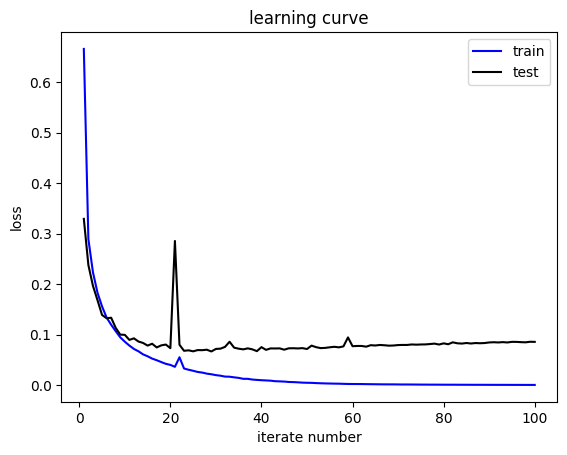

In [124]:
# 学習曲線の表示(損失)
plt.plot(history[:,0], history[:,1], "b", label="train")
plt.plot(history[:,0], history[:,3], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('loss')
plt.title('learning curve')
plt.legend()
plt.show()

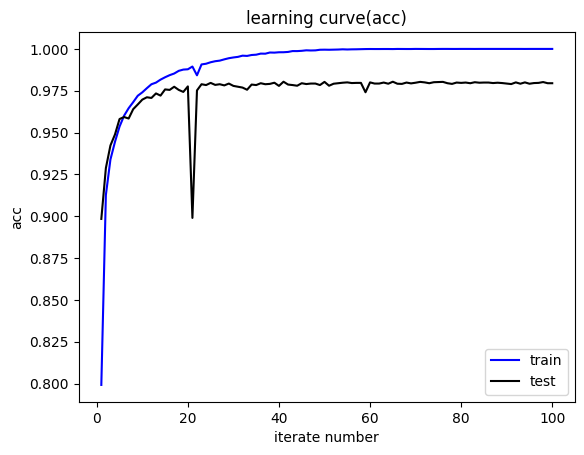

In [125]:
# 学習曲線の表示(精度)
plt.plot(history[:,0], history[:,2], "b", label="train")
plt.plot(history[:,0], history[:,4], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('acc')
plt.title('learning curve(acc)')
plt.legend()
plt.show()